## Feature Extraction (Chroma + Tonnetz + Spectral Contrast)


In [1]:
import os
import numpy as np
import librosa
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

DATA_DIR = 'preprocess'
SAMPLE_RATE = 16000
MAX_DURATION = 4  # seconds
MAX_LENGTH = SAMPLE_RATE * MAX_DURATION

def extract_combined_features(file_path, sr=SAMPLE_RATE):
    y, _ = librosa.load(file_path, sr=sr)

    # Pad or truncate
    if len(y) < MAX_LENGTH:
        y = np.pad(y, (0, MAX_LENGTH - len(y)))
    else:
        y = y[:MAX_LENGTH]

    # Chroma
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma = np.mean(chroma, axis=1)

    # Tonnetz
    y_harmonic = librosa.effects.harmonic(y)
    tonnetz = librosa.feature.tonnetz(y=y_harmonic, sr=sr)
    tonnetz = np.mean(tonnetz, axis=1)

    # Spectral contrast
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    contrast = np.mean(contrast, axis=1)

    # Combine all features
    combined = np.hstack([chroma, tonnetz, contrast])
    return combined

# Loop over dataset
X = []
y = []

for class_name in os.listdir(DATA_DIR):
    class_dir = os.path.join(DATA_DIR, class_name)
    if not os.path.isdir(class_dir):
        continue

    for file in os.listdir(class_dir):
        if file.endswith('.wav'):
            file_path = os.path.join(class_dir, file)
            features = extract_combined_features(file_path)
            X.append(features)
            y.append(class_name)

X = np.array(X)
y = np.array(y)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_onehot = to_categorical(y_encoded)

print(f"✅ Feature shape: {X.shape}, Labels: {y_onehot.shape}")


C:\Users\mypc\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


✅ Feature shape: (457, 25), Labels: (457, 5)


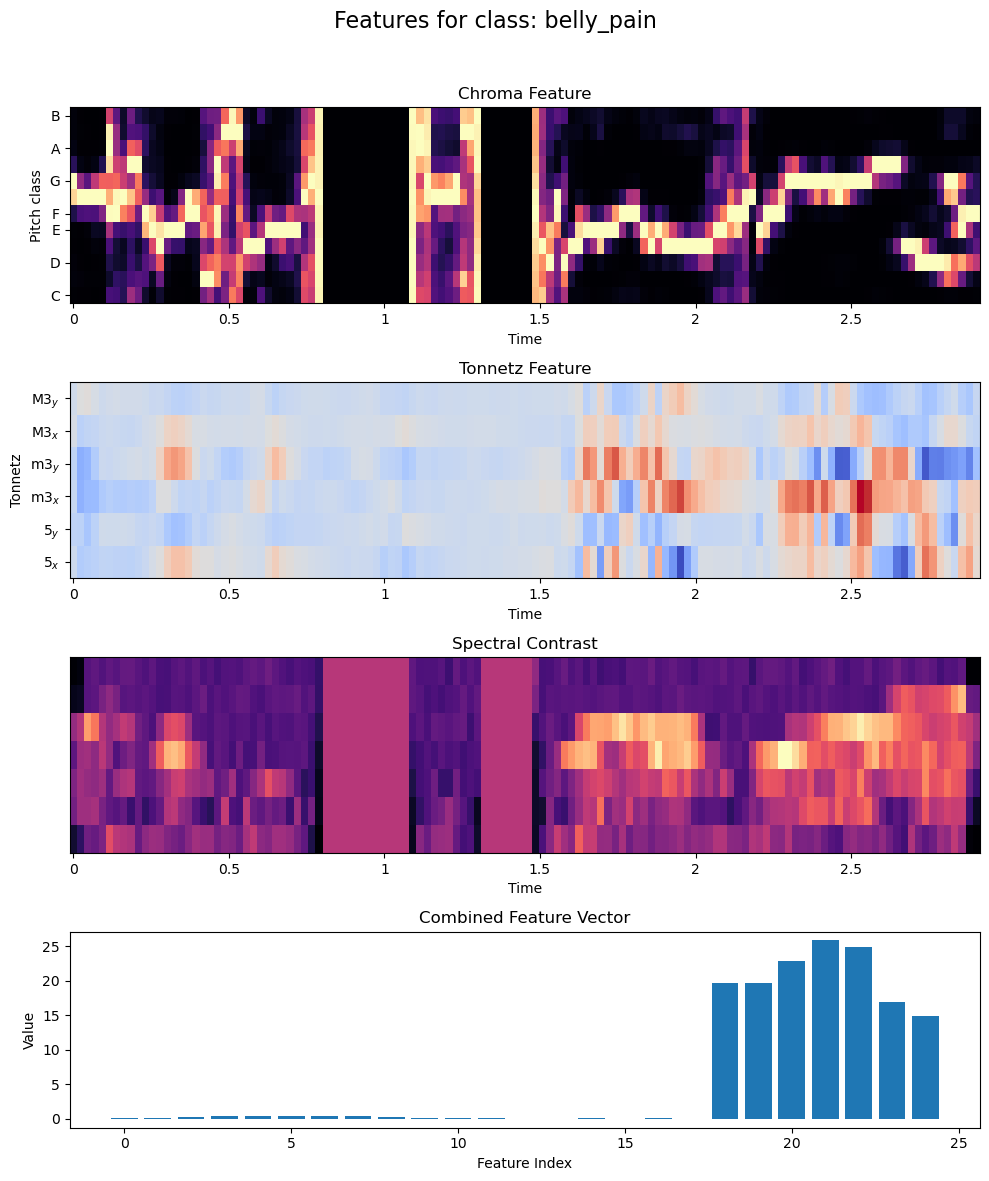

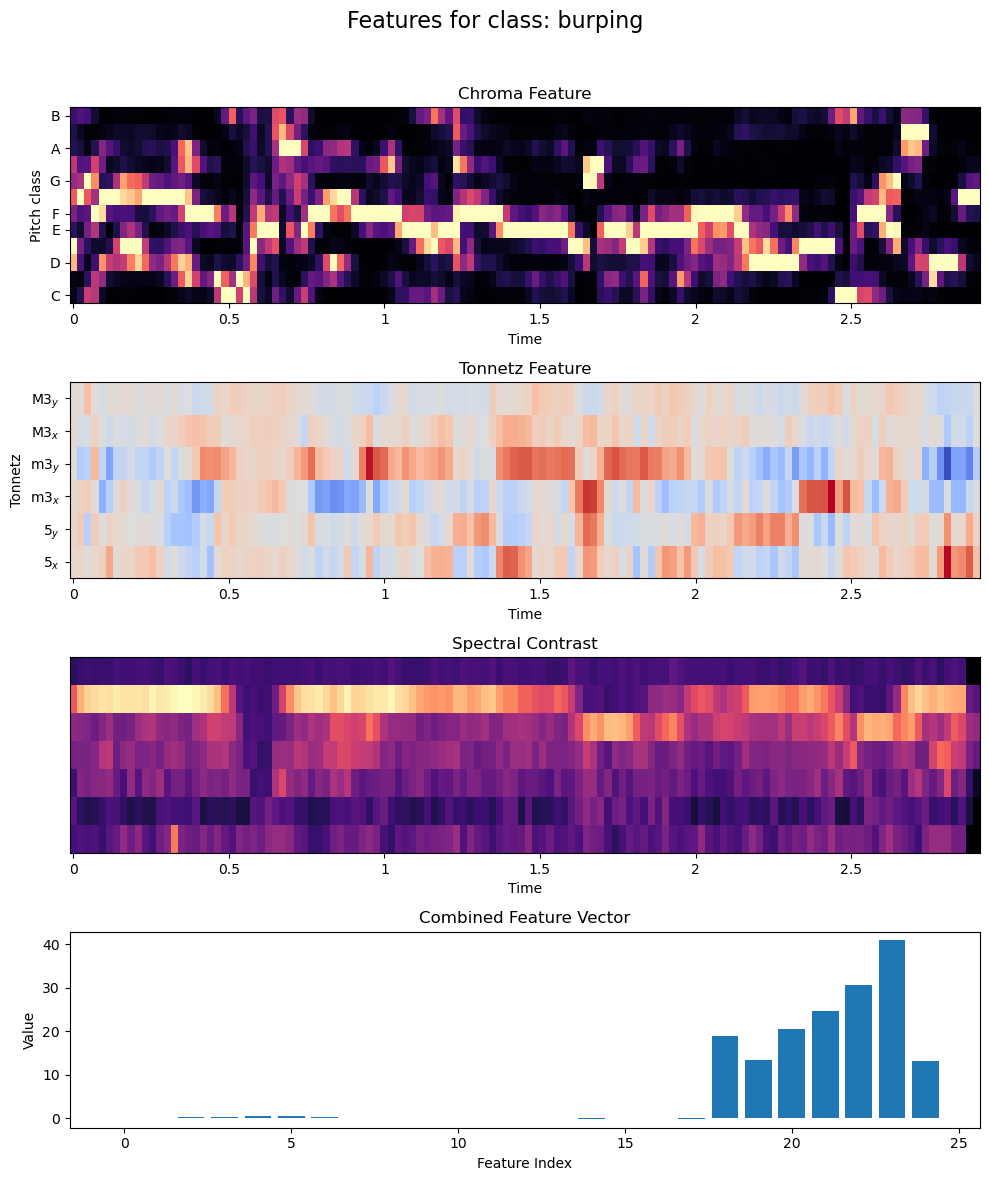

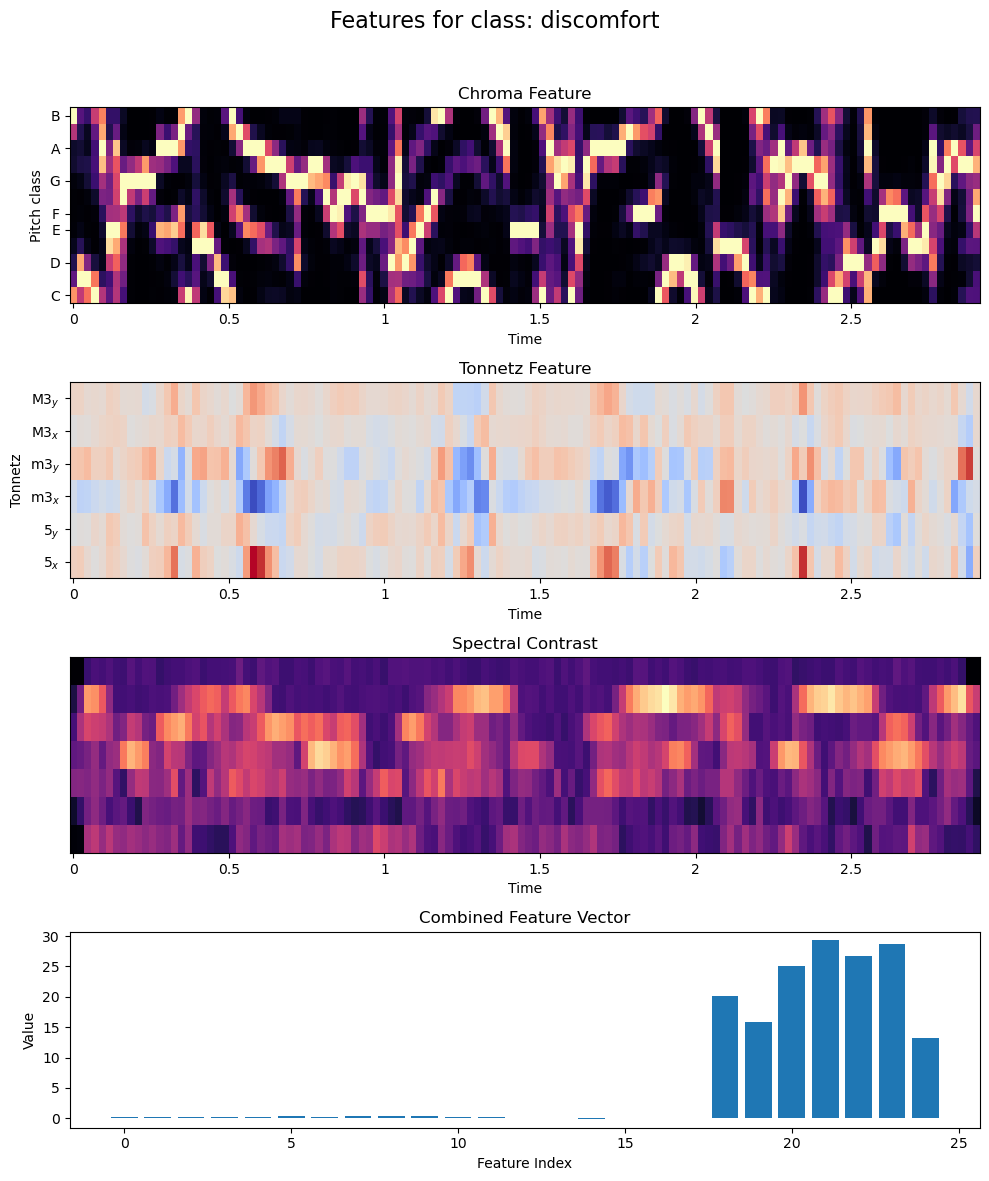

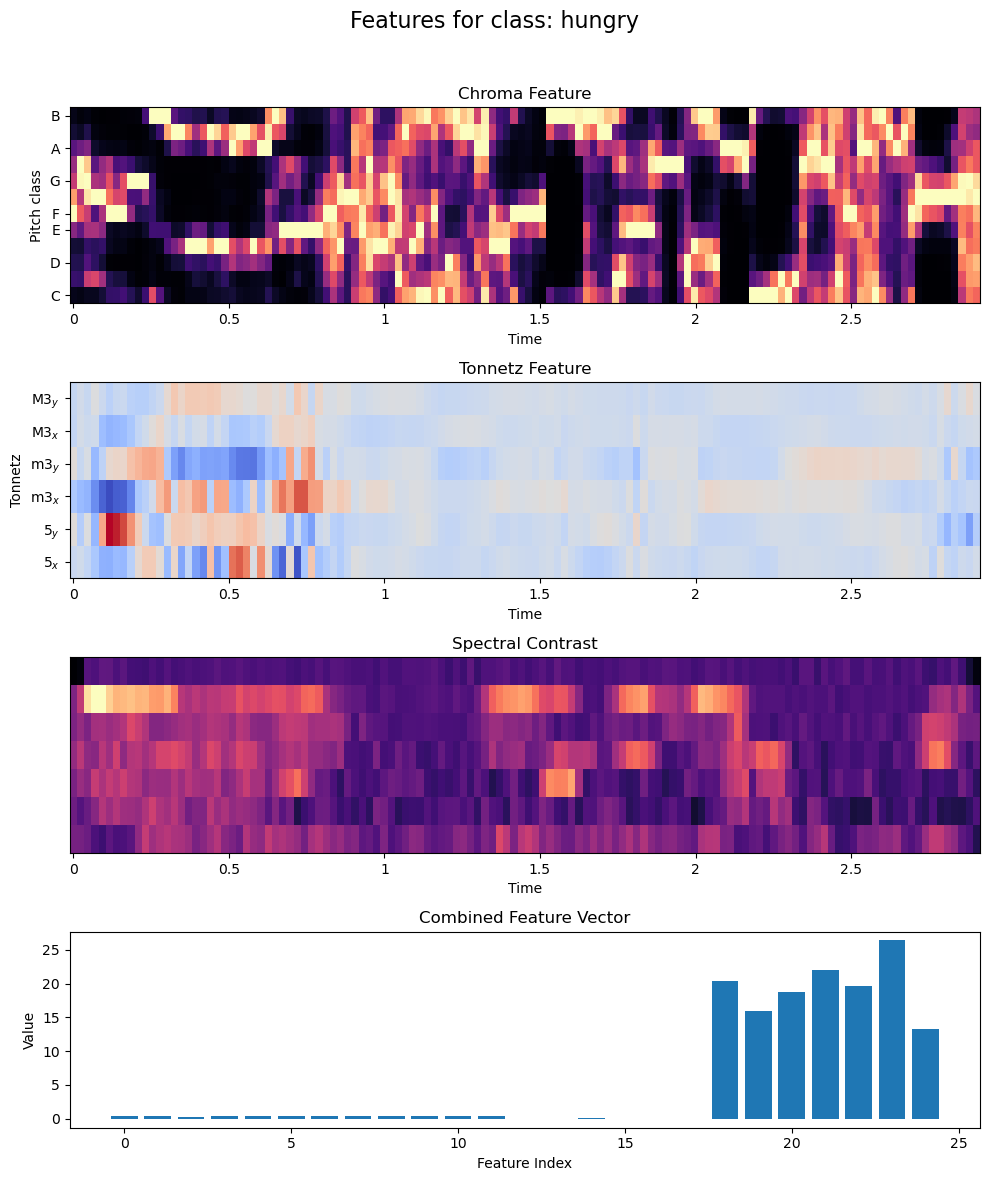

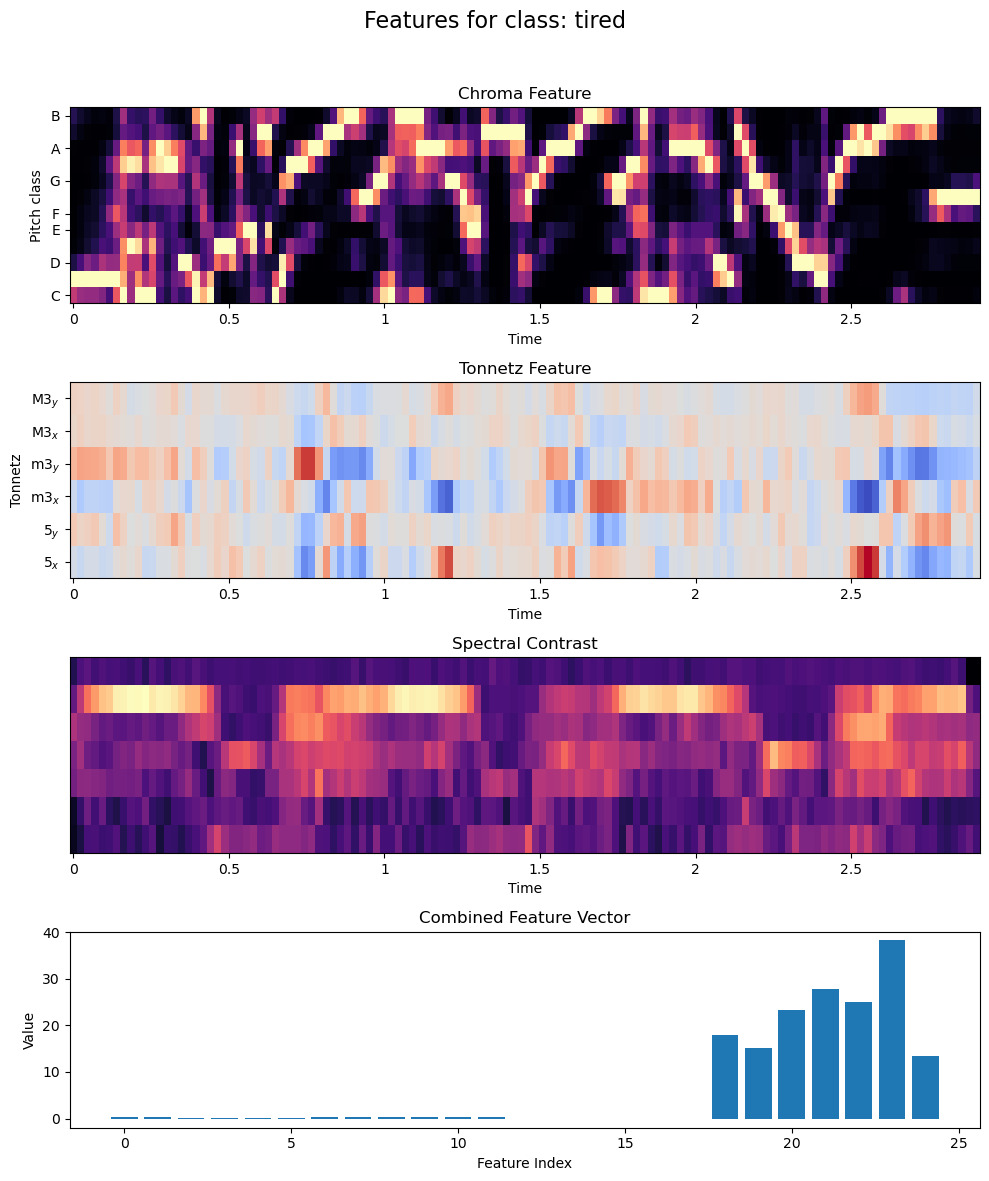

In [3]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

DATA_DIR = 'preprocess'
SAMPLE_RATE = 16000
MAX_DURATION = 4
MAX_LENGTH = SAMPLE_RATE * MAX_DURATION

def extract_and_plot_features(file_path, class_name):
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE)

    # Pad or truncate
    if len(y) < MAX_LENGTH:
        y = np.pad(y, (0, MAX_LENGTH - len(y)))
    else:
        y = y[:MAX_LENGTH]

    # Plotting
    fig, axs = plt.subplots(4, 1, figsize=(10, 12))
    fig.suptitle(f"Features for class: {class_name}", fontsize=16)

    # Chroma
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', ax=axs[0])
    axs[0].set_title("Chroma Feature")

    # Tonnetz
    y_harmonic = librosa.effects.harmonic(y)
    tonnetz = librosa.feature.tonnetz(y=y_harmonic, sr=sr)
    librosa.display.specshow(tonnetz, y_axis='tonnetz', x_axis='time', ax=axs[1])
    axs[1].set_title("Tonnetz Feature")

    # Spectral Contrast
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    librosa.display.specshow(contrast, x_axis='time', ax=axs[2])
    axs[2].set_title("Spectral Contrast")

    # Combined feature vector
    chroma_mean = np.mean(chroma, axis=1)
    tonnetz_mean = np.mean(tonnetz, axis=1)
    contrast_mean = np.mean(contrast, axis=1)
    combined = np.hstack([chroma_mean, tonnetz_mean, contrast_mean])
    
    axs[3].bar(range(len(combined)), combined)
    axs[3].set_title("Combined Feature Vector")
    axs[3].set_xlabel("Feature Index")
    axs[3].set_ylabel("Value")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Plot features for one audio file from each class
for class_name in os.listdir(DATA_DIR):
    class_path = os.path.join(DATA_DIR, class_name)
    if os.path.isdir(class_path):
        for file in os.listdir(class_path):
            if file.endswith('.wav'):
                file_path = os.path.join(class_path, file)
                extract_and_plot_features(file_path, class_name)
                break  # Only one audio per class


In [4]:
X

array([[ 0.138759  ,  0.16900229,  0.24579403, ..., 24.86841281,
        16.92199931, 14.93466437],
       [ 0.18840306,  0.1895473 ,  0.20966166, ..., 24.60408767,
        31.23256394, 13.43754916],
       [ 0.18971136,  0.20578271,  0.32941079, ..., 19.98841894,
        24.32117006, 13.68860728],
       ...,
       [ 0.16426712,  0.14054246,  0.20797254, ..., 29.16832704,
        43.49312329, 14.0904068 ],
       [ 0.19557005,  0.22186701,  0.33182889, ..., 26.63056361,
        33.30697052, 13.49364584],
       [ 0.17447783,  0.22839598,  0.28020415, ..., 28.69692491,
        28.47410925, 13.39768946]])

## Class Balancing

In [5]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Convert one-hot to integer labels for SMOTE
y_int = np.argmax(y_onehot, axis=1)

# Apply SMOTE to balance
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y_int)

# Convert labels back to one-hot
y_resampled_onehot = to_categorical(y_resampled)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled_onehot, test_size=0.2, random_state=42)

print(f"🔍After SMOTE → X: {X_train.shape}, y: {y_train.shape}")


After SMOTE → X: (1528, 25), y: (1528, 5)


In [7]:
from collections import Counter

# Before SMOTE: Count class distribution
print("Before SMOTE:")
class_counts_before = Counter(y_int)
for class_id, count in class_counts_before.items():
    print(f"Class {le.classes_[class_id]}: {count} samples")

# After SMOTE: Count class distribution
print("\nAfter SMOTE:")
class_counts_after = Counter(y_resampled)
for class_id, count in class_counts_after.items():
    print(f"Class {le.classes_[class_id]}: {count} samples")


Before SMOTE:
Class belly_pain: 16 samples
Class burping: 8 samples
Class discomfort: 27 samples
Class hungry: 382 samples
Class tired: 24 samples

After SMOTE:
Class belly_pain: 382 samples
Class burping: 382 samples
Class discomfort: 382 samples
Class hungry: 382 samples
Class tired: 382 samples


## Model Development (Hybrid CNN-RNN)

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, LSTM, Dropout, Flatten, Reshape

# Reshape data to fit CNN input (samples, features, 1)
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define the hybrid CNN-RNN model
model = Sequential()

# CNN Layers
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)))  # Input shape = (25, 1)
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))  # Dropout for regularization

model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

# Flatten the output from CNN layers
model.add(Flatten())

# Reshape the data to make it suitable for LSTM
model.add(Reshape((-1, 256)))  # Reshape output to (batch_size, time_steps, features) for LSTM

# RNN (LSTM) Layers
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(y_train.shape[1], activation='softmax'))  # Output layer for multi-class classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()




Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 23, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 11, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 11, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 9, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 4, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 4, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 2, 256)              │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 1, 128)              │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 370,373 (1.41 MB)

 Trainable params: 370,373 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define callbacks for learning rate adjustment and early stopping
lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                 patience=2, 
                                 verbose=1, 
                                 factor=0.5, 
                                 min_lr=0.0001)  # Reduce LR by half if no improvement in 2 epochs

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5, 
                               restore_best_weights=True, 
                               verbose=1)  # Stop training if no improvement for 5 epochs

# Fit the model with the callbacks
history = model.fit(
    X_train_reshaped, y_train, 
    epochs=20, 
    batch_size=32, 
    validation_data=(X_test_reshaped, y_test), 
    callbacks=[lr_reduction, early_stopping]
)


Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5929 - loss: 0.9814 - val_accuracy: 0.6728 - val_loss: 0.7780 - learning_rate: 2.5000e-04
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5917 - loss: 0.9618 - val_accuracy: 0.6806 - val_loss: 0.7744 - learning_rate: 2.5000e-04
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6227 - loss: 0.9445 - val_accuracy: 0.6597 - val_loss: 0.7903 - learning_rate: 2.5000e-04
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6035 - loss: 0.9552 - val_accuracy: 0.6885 - val_loss: 0.7735 - learning_rate: 2.5000e-04
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6386 - loss: 0.9309 - val_accuracy: 0.6859 - val_loss: 0.7625 - learning_rate: 2.5000e-04
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6297 - loss: 0.9150 - val_accuracy: 0.6754 - val_loss: 0.7606 - learning_rate: 2.5000e-04
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6377 

In [16]:
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test)
print(f"Test Accuracy: {test_accuracy}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6863 - loss: 0.7336
Test Accuracy: 0.6937173008918762


## Model Evaluation 

In [19]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Convert y_test to class labels (if it's one-hot encoded)
y_test_class = np.argmax(y_test, axis=1)

# Predict using the model
y_pred = model.predict(X_test_reshaped)
y_pred_class = y_pred.argmax(axis=1)

# Print classification report and confusion matrix
print(classification_report(y_test_class, y_pred_class))


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
              precision    recall  f1-score   support

           0       0.68      0.92      0.78        73
           1       0.83      1.00      0.91        72
           2       0.70      0.79      0.74        80
           3       0.78      0.17      0.27        84
           4       0.55      0.67      0.60        73

    accuracy                           0.69       382
   macro avg       0.71      0.71      0.66       382
weighted avg       0.71      0.69      0.65       382



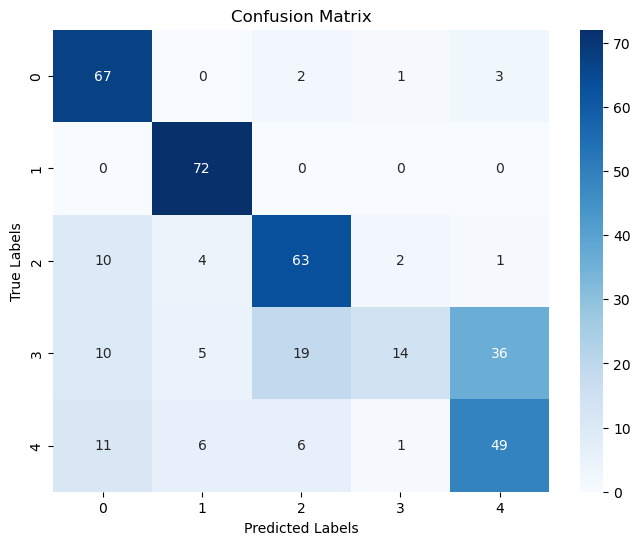

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_pred_class are available in your environment
y_test_class = y_test.argmax(axis=1)  # Convert one-hot encoding to class labels

# Compute confusion matrix
cm = confusion_matrix(y_test_class, y_pred_class)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(cm.shape[1]), yticklabels=range(cm.shape[0]))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


## Model Saving

In [23]:
# Save the model in .h5 format
model.save('cry_classification_cts_model.h5')
